In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Check CUDA version and GPU

In [1]:
!nvcc --version
!nvidia-smi

zsh:1: command not found: nvcc
Sun Jul 28 17:49:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:2B:00.0  On |                  N/A |
| 34%   52C    P0             43W /  170W |     552MiB /  12288MiB |     15%      Default |
|                                         |                        |                  N/A |
+----------------

In [ ]:
!pip install scikit-image
!pip install matplotlib

import libraries and check GPU (the first time you import cellpose the models will download).

In [2]:
# Importa bibliotecas e verifica se a GPU está ativa

import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse;
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();


>>> GPU activated? 1
2024-07-28 22:02:50,503 [INFO] WRITING LOG OUTPUT TO /home/duardo/.cellpose/run.log
2024-07-28 22:02:50,503 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.12.4 
torch version:  	2.3.1+cu121


['soja5/Pic_2023_09_03_203955_3877.tiff']
1
(1200, 1920)


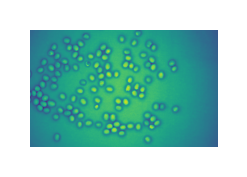

In [4]:
from cellpose import utils
import random

# Pasta raiz com as imagens de soja
image_folder_path = 'soja'

# Inicia vetor de arquivos 
files = []

# Percorre as pastas de imagens e seleciona um arquivo aleatório de cada pasta
# O objetivo de fazer isso é selecioanr uma imagem com um onda de luz aleatória e usa-la para a segmentação
folders = os.listdir(image_folder_path)
for folder in folders:
  # Pega todos os arquivos da pasta em ordem alfabética
  # E remove os dois primeiros arquivos que são uma captura que está tudo preto
  folder_path = os.path.join(image_folder_path, folder)
  _files = sorted(os.listdir(folder_path))
  _files = [f for f in _files[2:] if f.endswith('.tiff')] 

  if _files:
    # Seleciona um arquivo aleatório e adiciona no vetor de arquivos no formato 'pasta/arquivo'
    selected_file = random.choice(_files)
    files.append(os.path.join(folder, selected_file))
  break

# Ordena os arquivos separados por pasta
files = sorted(files)

# files = files[:10]
print(files)
print(len(files))

# Utiliza a função imread do skimage para carregar as imagens
# A função imread carrega as imagens em um array numpy
# O array numpy é uma matriz com as dimensões da imagem e os valores dos pixels
imgs = [skimage.io.imread(os.path.join(image_folder_path, f)) for f in files]
nimg = len(imgs)
print(imgs[0].shape)


# Crio uma figura  10x5 para mostrar as imagens e visualizar se estão corretas
plt.figure(figsize=(8,6))
for k,img in enumerate(imgs):
   plt.subplot(10, 5 ,k+1)
   plt.axis('off')
   plt.imshow(img)
plt.savefig("amostras")

In [6]:
imgs_2D = imgs

from cellpose import models

# Carrega o modelo de segmentação Cellpose utilizando a GPU
# Com o model_type='cyto3' pois esse é o modelo mais generalista
model = models.Cellpose(gpu=use_GPU, model_type='cyto3')

# Define os canais de segmentação
# grayscale=0, R=1, G=2, B=3
# Se todas imagens forem do mesmo tipo, lista com 2 elementos
# channels = [0,0] # Para escala de cinza
channels = [0,0]

# Chama o modelo para analisar as imagens
# Diaemtro = 60 representa o tamanho médio dos grãos de soja
# flow_threshold = None representa que não há um threshold para o fluxo. Threshold é um valor que define o quanto de fluxo é necessário para considerar um objeto em movimento
masks, flows, styles, diams = model.eval(imgs_2D, diameter=60, flow_threshold=None, channels=channels)

# Tempo médio de execução para 50 imagens de 1920x1200 é de 40 segundos
# Ao final da execução, o modelo retorna as máscaras de segmentação, os fluxos e os estilos de segmentação e os diâmetros

2024-07-28 22:09:38,689 [INFO] ** TORCH CUDA version installed and working. **
2024-07-28 22:09:38,689 [INFO] >>>> using GPU
2024-07-28 22:09:38,690 [INFO] >> cyto3 << model set to be used
2024-07-28 22:09:38,742 [INFO] >>>> loading model /home/duardo/.cellpose/models/cyto3
2024-07-28 22:09:38,818 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-07-28 22:09:38,819 [INFO] channels set to [0, 0]
2024-07-28 22:09:38,820 [INFO] ~~~ FINDING MASKS ~~~
2024-07-28 22:09:39,924 [INFO] >>>> TOTAL TIME 1.10 sec


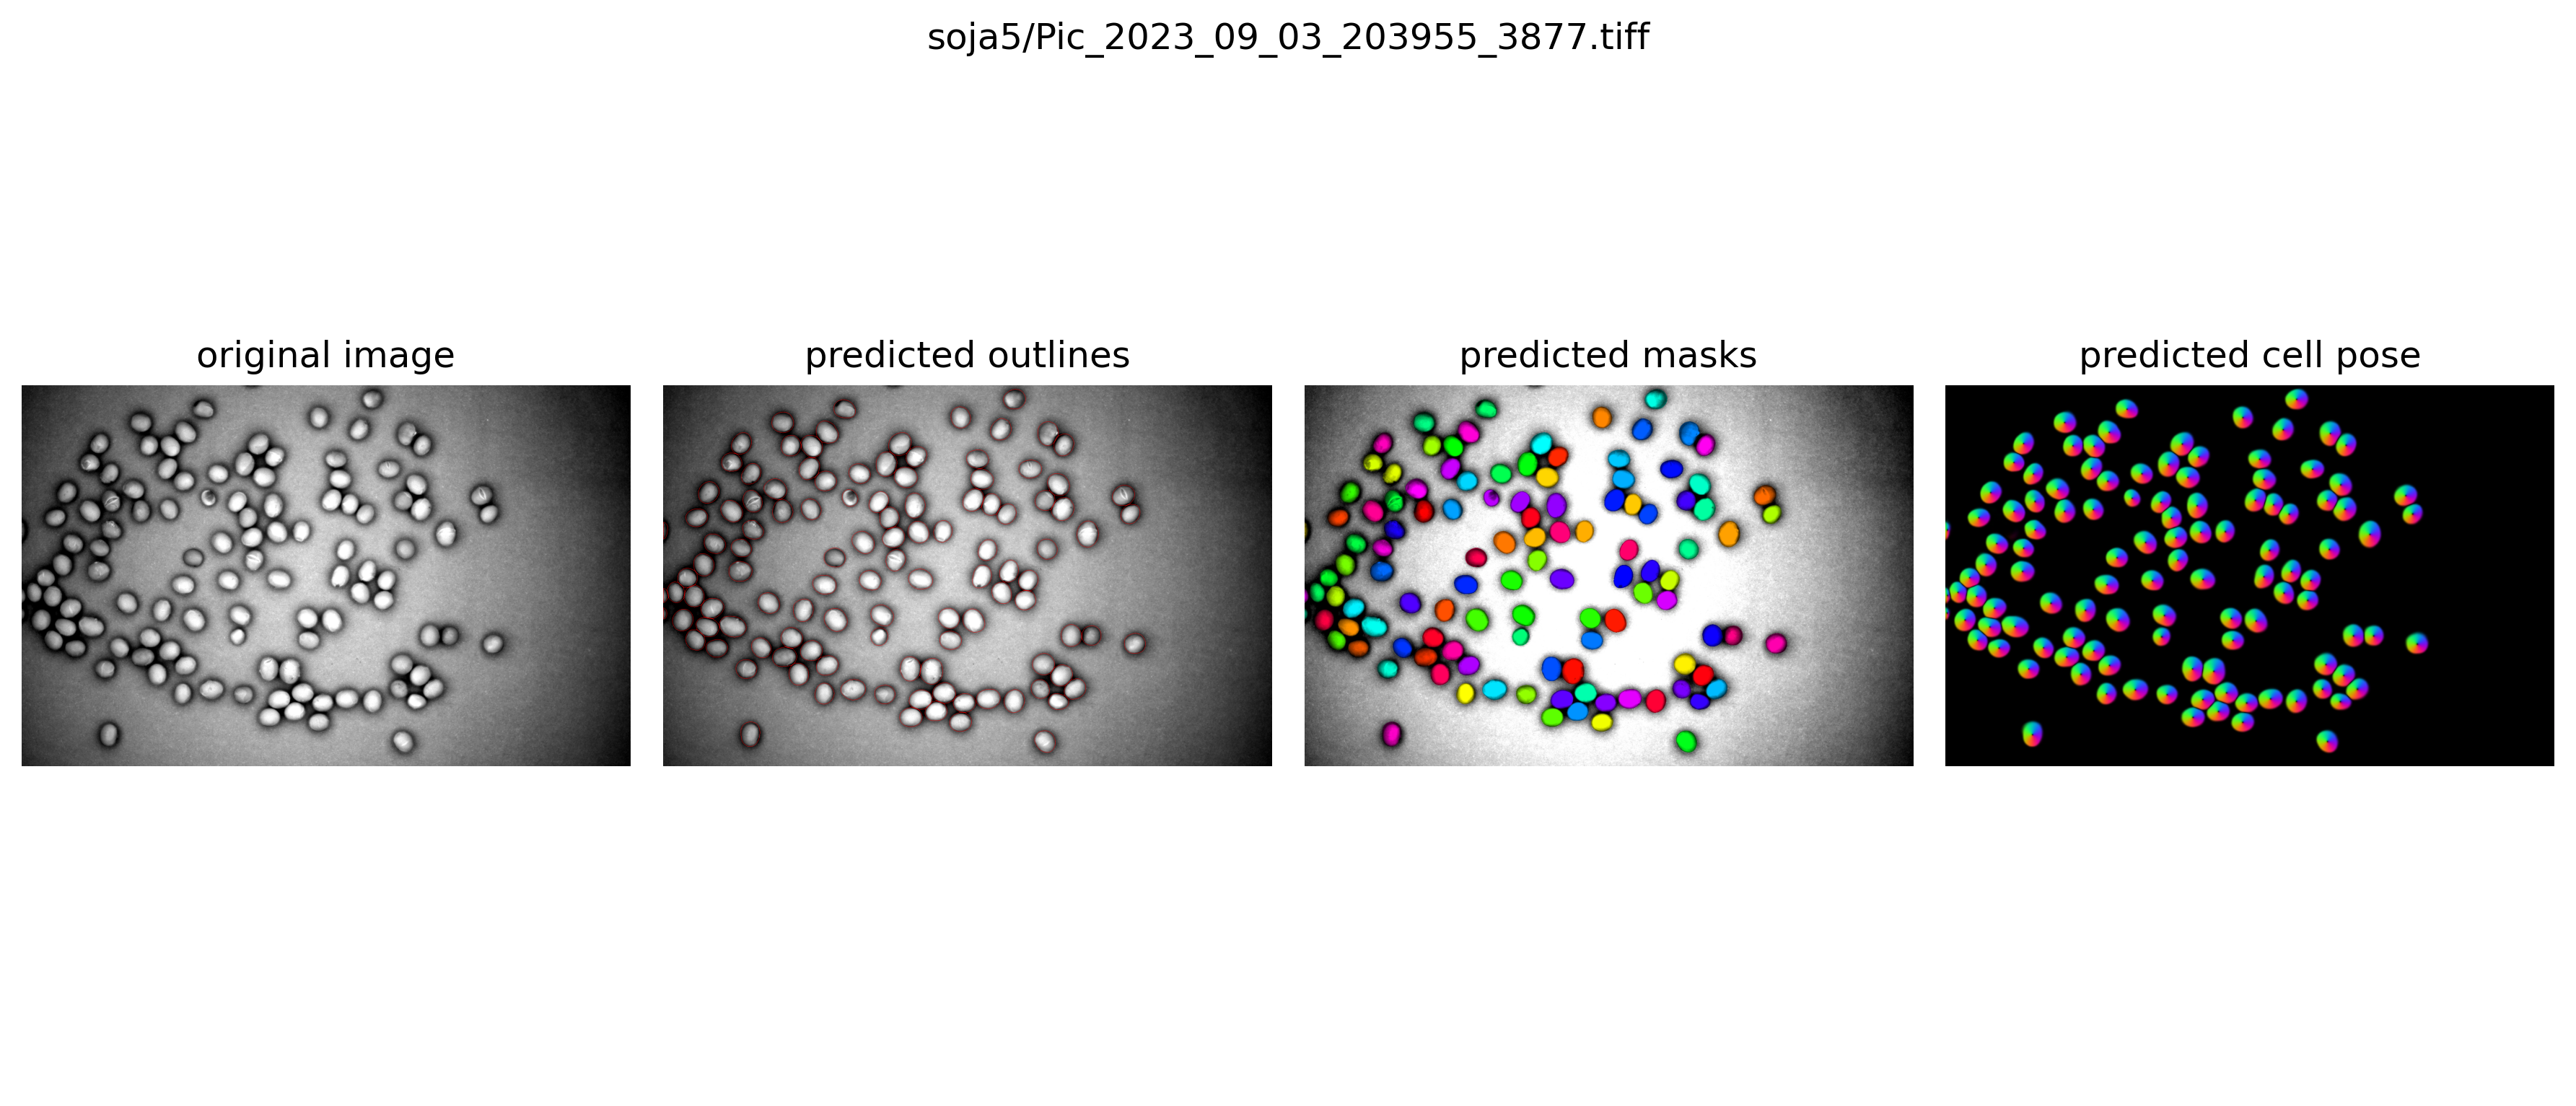

In [9]:
from cellpose import plot

# Processo de visualização das imagens segmentadas
# Para cada imagem, é mostrado a imagem original, a máscara de segmentação e o fluxo de segmentação
nimg = len(imgs_2D)
for idx in range(1):
    maski = masks[idx]
    flowi = flows[idx][0]
    file = files[idx]
    fig = plt.figure(figsize=(12,5))
    plt.title(file)
    plt.axis("off")
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels, file_name="segmentacao.png")
    plt.tight_layout()
    plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


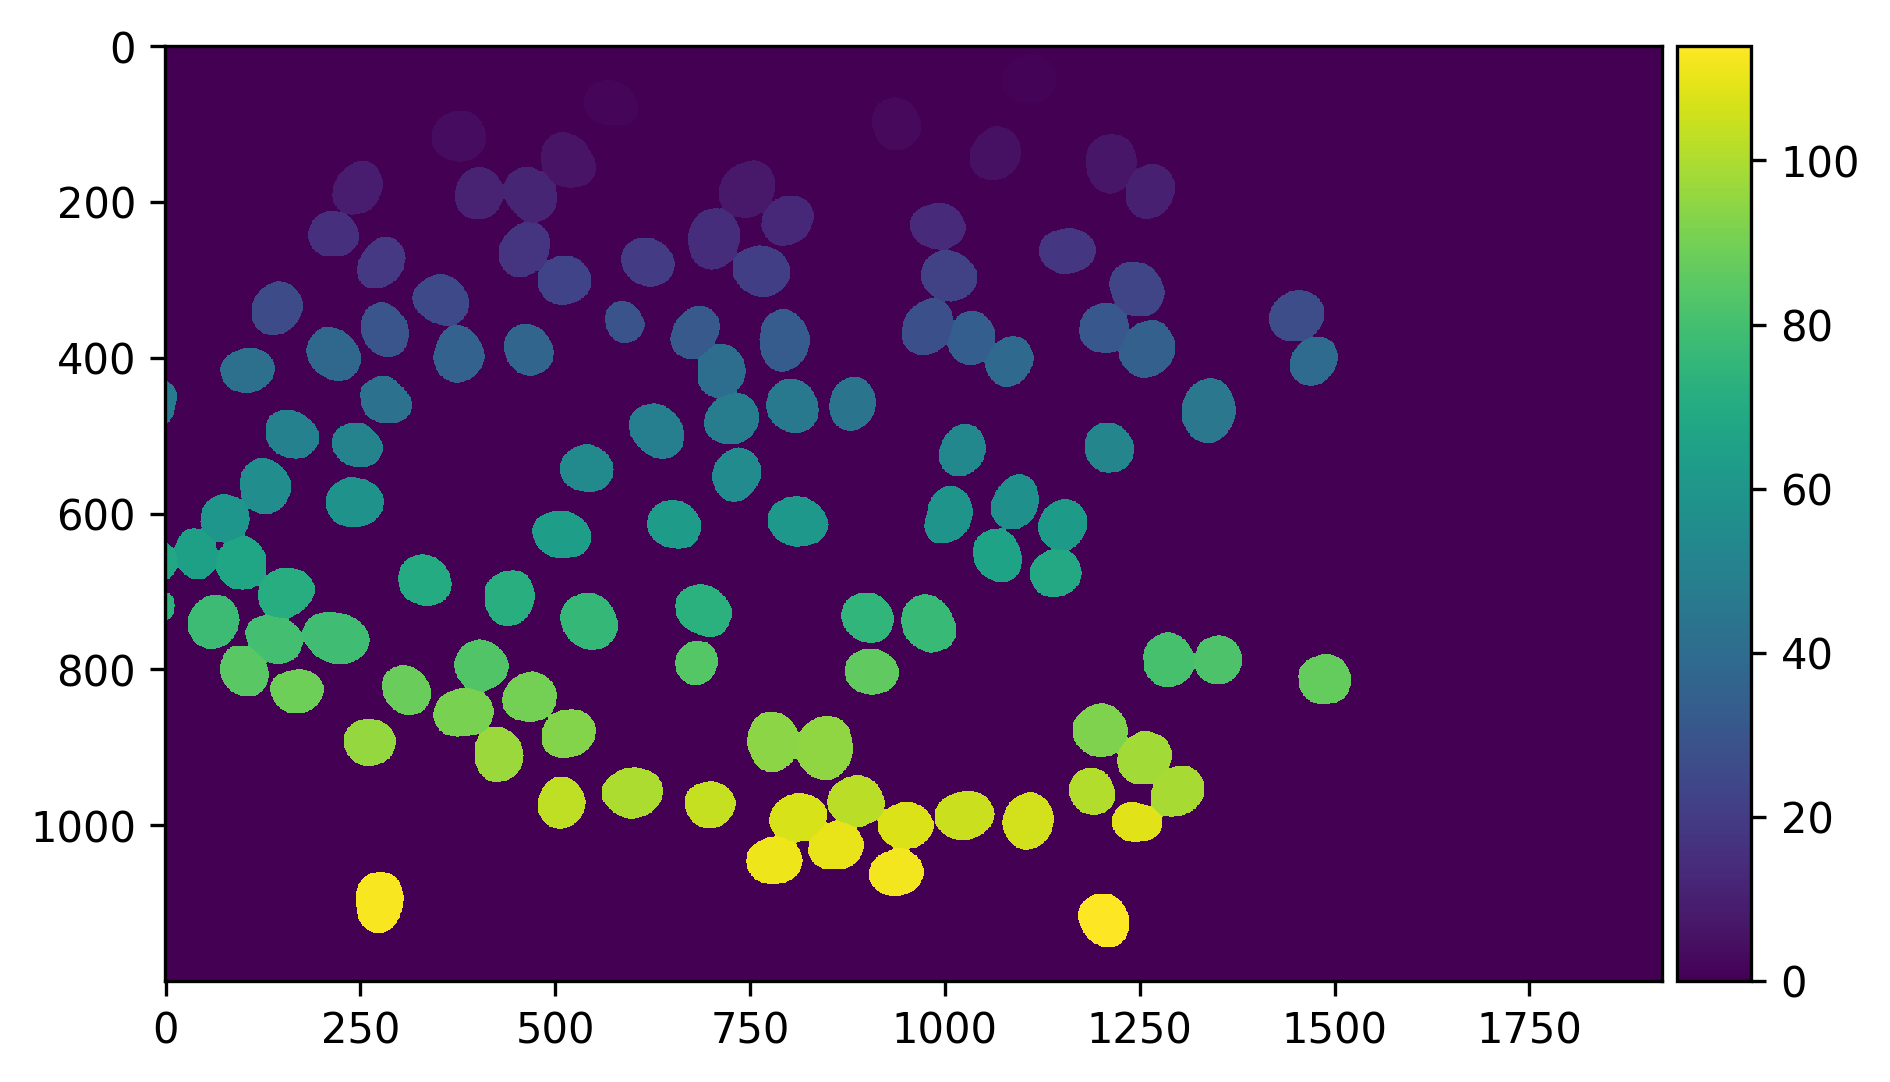

In [18]:
print(masks[0])
skimage.io.imshow(masks[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114]
percorrendo soja5
0
1


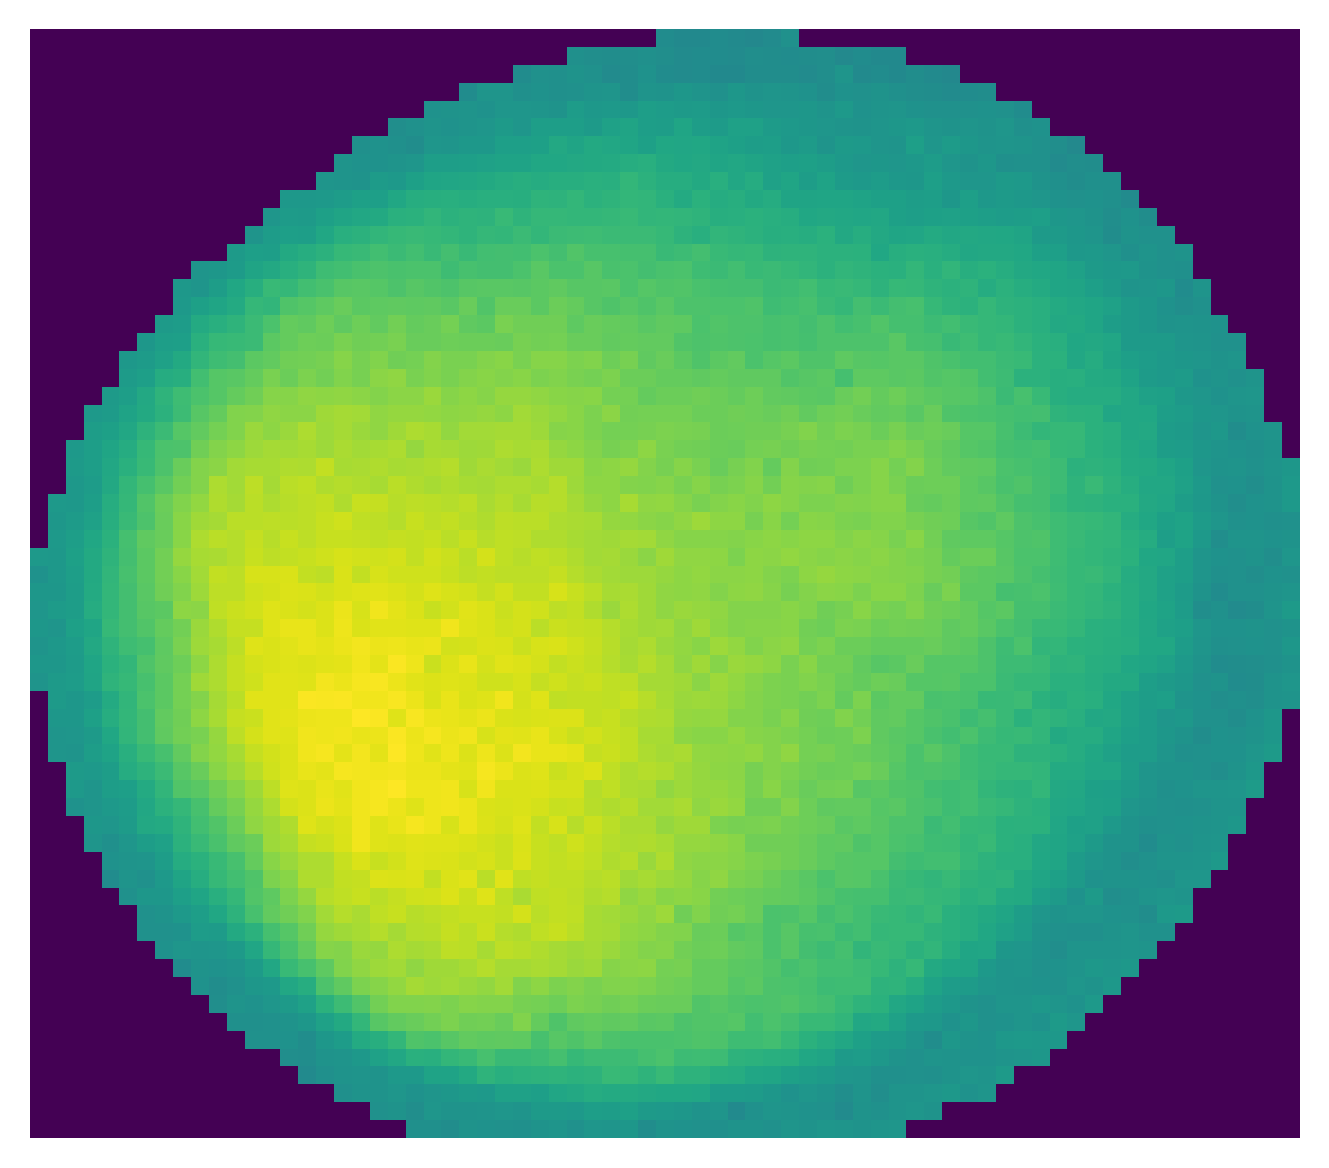

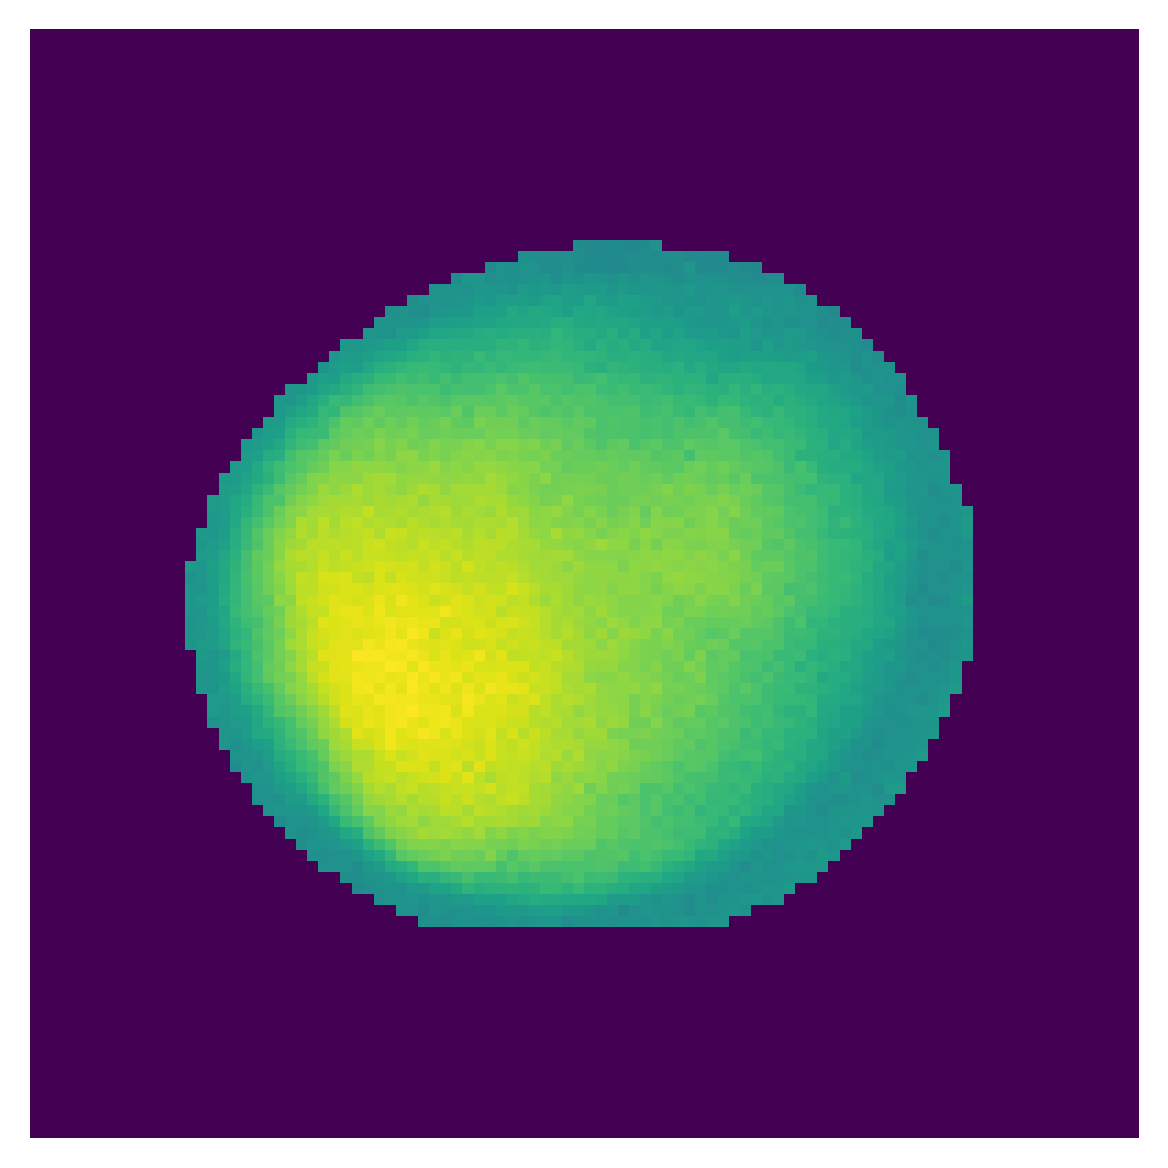

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from PIL import Image

nimg = len(imgs_2D)

# Processo para cortar as imagens de acordo com as máscaras de segmentação
for idx in range(nimg):

    # Maski é a máscara de segmentação da imagem idx
    maski = masks[idx]
    # File é o caminho da imagem idx
    file = files[idx]

    # Label é o nome da pasta onde a imagem está
    label = file.split('/')[0]
    

    # Rótulos únicos na máscara
    seeds = np.unique(maski)
    print(maski)
    print(seeds)
    
    # Se o seed for 0, é o fundo da imagem
    # Se o seed for diferente de 0, é um grão de soja
    # Calcula a área de cada grão de soja e a média das áreas
    areas = [np.sum(maski == seed) for seed in seeds if seed != 0] 

    # A média é calculada para remover grãos muito pequenos que podem ser ruídos
    mean_area = np.mean(areas)
    
    # Caminho da pasta onde as imagens estão
    # Pega a raiz aonde está o grão o label que está sendo analizado no momento
    # Isso porque a segmentação foi feita em cima de uma única imagem, agora precisamos
    # aplicar o recorte em cada imagem da pasta, pois cada imagem representa uma onda de luz diferente
    imgs_folder = os.path.join(image_folder_path, label)
    print(f'percorrendo {label}')

    # Pega todos os arquivos da pasta em ordem alfabética
    _files = sorted(os.listdir(imgs_folder))
    # Remove os dois primeiros arquivos que são uma captura que está tudo preto e pega apenas os arquivos .tiff
    _files = [f for f in _files[2:] if f.endswith('.tiff')]


    # Lista de todas as imagens da pasta
    list_imgs = _files


    i = 0 # Id  do grão de soja

    # Para cada grão de soja de uma imagem idx será feito o recorte em todas as imagens da pasta
    for seed in seeds:
        print(seed)
        # Ignora o fundo
        if seed == 0:
            continue  

        # Verifica se a área desse grão é menor que a média dividida por 2
        area = np.sum(maski == seed)
        if area < mean_area/2:
            continue
        
        j = 0 # Id da onda de luz
        for f in list_imgs:
            # Carrega a imagem
            img = skimage.io.imread(os.path.join(imgs_folder, f))

            # Crie uma nova imagem onde apenas os pixels com o rótulo atual são visíveis
            # Basicamente, a máscara é aplicada na imagem
            # Utilizando a função np.where onde se o pixel for igual ao seed, ele pega o pixel da imagem, senão, ele coloca 0
            # 0 representa a cor preta
            segmented_img = np.where(maski == seed, img, 0)

            # Aqui o seed é a posição do grão de soja na imagem
            # Maski é a máscara de segmentação da imagem idx
            # seed == maski retorna as coordenadas x e y do grão de soja em dois arrays
            y, x = np.where(maski == seed)
            center_x, center_y = np.mean(x), np.mean(y)

            # Calcule os limites do recorte
            xmin = np.min(x)
            xmax = np.max(x)
            ymin = np.min(y)
            ymax = np.max(y)


            # Pega a imagem segmentada e recorta de acordo com os limites calculados
            cropped_img = segmented_img[ymin:ymax, xmin:xmax]
            plt.imshow(cropped_img)
            plt.axis('off')
            plt.show()

            # Cria a pasta _recortado/label se não existir 
            os.makedirs(os.path.join('_recortado', label), exist_ok=True)
            # Cria o nome do arquivo de saída. label representa um grão de soja, i é o id do grão de soja e j é o id da onda de luz
            output_filename = f"label_{i}_{j}.tiff"
            output_path = os.path.join('_recortado', label, output_filename)

            # Exibir a imagem recortada
            # plt.subplot(1, 31 , j+1)
            # plt.axis('off')
            # plt.imshow(cropped_img)

            # Utilizando a biblioteca PIL para salvar a imagem recortada em um tamanho fixo de 100x100
            # Carrega a imagem recortada em um objeto PIL
            cropped_pil = Image.fromarray(cropped_img)

            # Define o tamanho de saída
            # new ("L", output_size) cria uma nova imagem em escala de cinza com o tamanho de saída
            output_size = (100,100)
            new_img = Image.new("L", output_size)

            # Calcula a posição x e y para centralizar a imagem recortada na imagem de saída
            # Pega o tamanho da imagem recortada e subtrai do tamanho de saída e divide por 2
            x = (output_size[0] - cropped_pil.width) // 2
            y = (output_size[1] - cropped_pil.height) // 2
            new_img.paste(cropped_pil, (x, y))
                
            # Salva a imagem recortada no formato tiff
            #new_img.save(output_path, format='TIFF')

            plt.imshow(new_img)
            plt.axis('off')
            plt.show()
            j+=1
            break
        break
            
        i += 1